In [1]:
from axisvm.com.client import start_AxisVM
axvm = start_AxisVM(visible=True, daemon=True)

In [2]:
import axisvm.com.tlb as axtlb
import os
modelId = axvm.Models.New()
axm = axvm.Models.Item[modelId]
wdir = os.getcwd()


IAxisVMModel,Information
N Nodes,0
N Lines,0
N Members,0
N Surfaces,0
N Domains,0


In [3]:
L = 10.0  # length of the beam
h = 0.02  # height of the cross-section
b = 4.0  # width of the cross section
q = -0.1  # intensity of vertical distributed load

In [4]:

axm.Settings.NationalDesignCode = axtlb.ndcEuroCode
matId = axm.Materials.AddFromCatalog(axtlb.ndcEuroCode, "S 235")

In [5]:
import numpy as np
from axisvm.com.tlb import dofPlateXY

# the plate is in the x-y plane
coords = np.zeros((4, 3))  # we have four points in 3d space
coords[0, :] = 0., -b/2, 0.
coords[1, :] = L, -b/2, 0.
coords[2, :] = L, b/2, 0.
coords[3, :] = 0., b/2, 0.

fnc = axm.Nodes.AddWithDOF
nodeIDs = list(map(lambda c: fnc(*c, dofPlateXY), coords))

In [6]:
nodes_of_lines = [[0, 1], [1, 2], [2, 3], [3, 0]]
LineGeomType = axtlb.lgtStraightLine
lineIDs = []
for line in nodes_of_lines:
    lineIDs.append(axm.Lines.Add(nodeIDs[line[0]], nodeIDs[line[1]],
                   LineGeomType, axtlb.RLineGeomData())[1])

In [7]:
from axisvm.com.tlb import RSurfaceAttr, lnlTensionAndCompression, \
    RResistancesXYZ, schLinear, stPlate, RElasticFoundationXYZ, \
    RNonLinearityXYZ, xtldLocalX

sattr = RSurfaceAttr(
    Thickness=h,
    SurfaceType=stPlate,
    RefZId=0,
    RefXId=0,
    MaterialId=matId,
    ElasticFoundation=RElasticFoundationXYZ(0, 0, 0),
    NonLinearity=RNonLinearityXYZ(lnlTensionAndCompression,
                                  lnlTensionAndCompression,
                                  lnlTensionAndCompression),
    Resistance=RResistancesXYZ(0, 0, 0),
    Charactersitics=schLinear)

id = axm.Domains.Add(LineIds=lineIDs, SurfaceAttr=sattr)[1]
#im = axm.XLAMPanels.AddFromCatalog('Binderholz', '3(90)')
#axm.Domains.SetXLAMParameters(id, im, xtldLocalX)

In [8]:
LoadDomainConstant = axtlb.RLoadDomainConstant(
    LoadCaseId=1, DomainId=1,
    qx=0, qy=0, qz=q,
    DistributionType=axtlb.sddtSurface,
    SystemGLR=axtlb.sysLocal
)
case_1_id = axm.Loads.AddDomainConstant(LoadDomainConstant)

In [9]:
springleft = axtlb.RStiffnesses(
    x=1e12,
    y=1e12,
    z=1e12,
    xx=0,
    yy=0,
    zz=0
)
springright = axtlb.RStiffnesses(
    x=1e12,
    y=1e12,
    z=1e12,
    xx=0,
    yy=0,
    zz=0
)
RNonLinearity = axtlb.RNonLinearity(
    x=axtlb.lnlTensionAndCompression,
    y=axtlb.lnlTensionAndCompression,
    z=axtlb.lnlTensionAndCompression,
    xx=axtlb.lnlTensionAndCompression,
    yy=axtlb.lnlTensionAndCompression,
    zz=axtlb.lnlTensionAndCompression
)
RResistances = axtlb.RResistances(
    x=0,
    y=0,
    z=0,
    xx=0,
    yy=0,
    zz=0
)
_ = axm.LineSupports.AddEdgeGlobal(springleft, RNonLinearity,
                                   RResistances, 2, 0, 0, 1, 0)
_ = axm.LineSupports.AddEdgeGlobal(springright, RNonLinearity,
                                   RResistances, 4, 0, 0, 1, 0)

In [10]:
MeshParams = axtlb.RDomainMeshParameters(
    MeshSize=b/10,
    MeshType=axtlb.mtUniform,
    MeshGeometryType=axtlb.mgtTriangle
)
axm.Domains[:].GenerateMesh(MeshParams)

 (),
 (),
 (),
 1]

In [11]:
fpath = wdir + '//FEM//AxisVM//ss_beam_P.axs'
axm.SaveToFile(fpath, False)
axm.Calculation.LinearAnalysis(axtlb.cuiNoUserInteractionWithAutoCorrectNoShow)

1

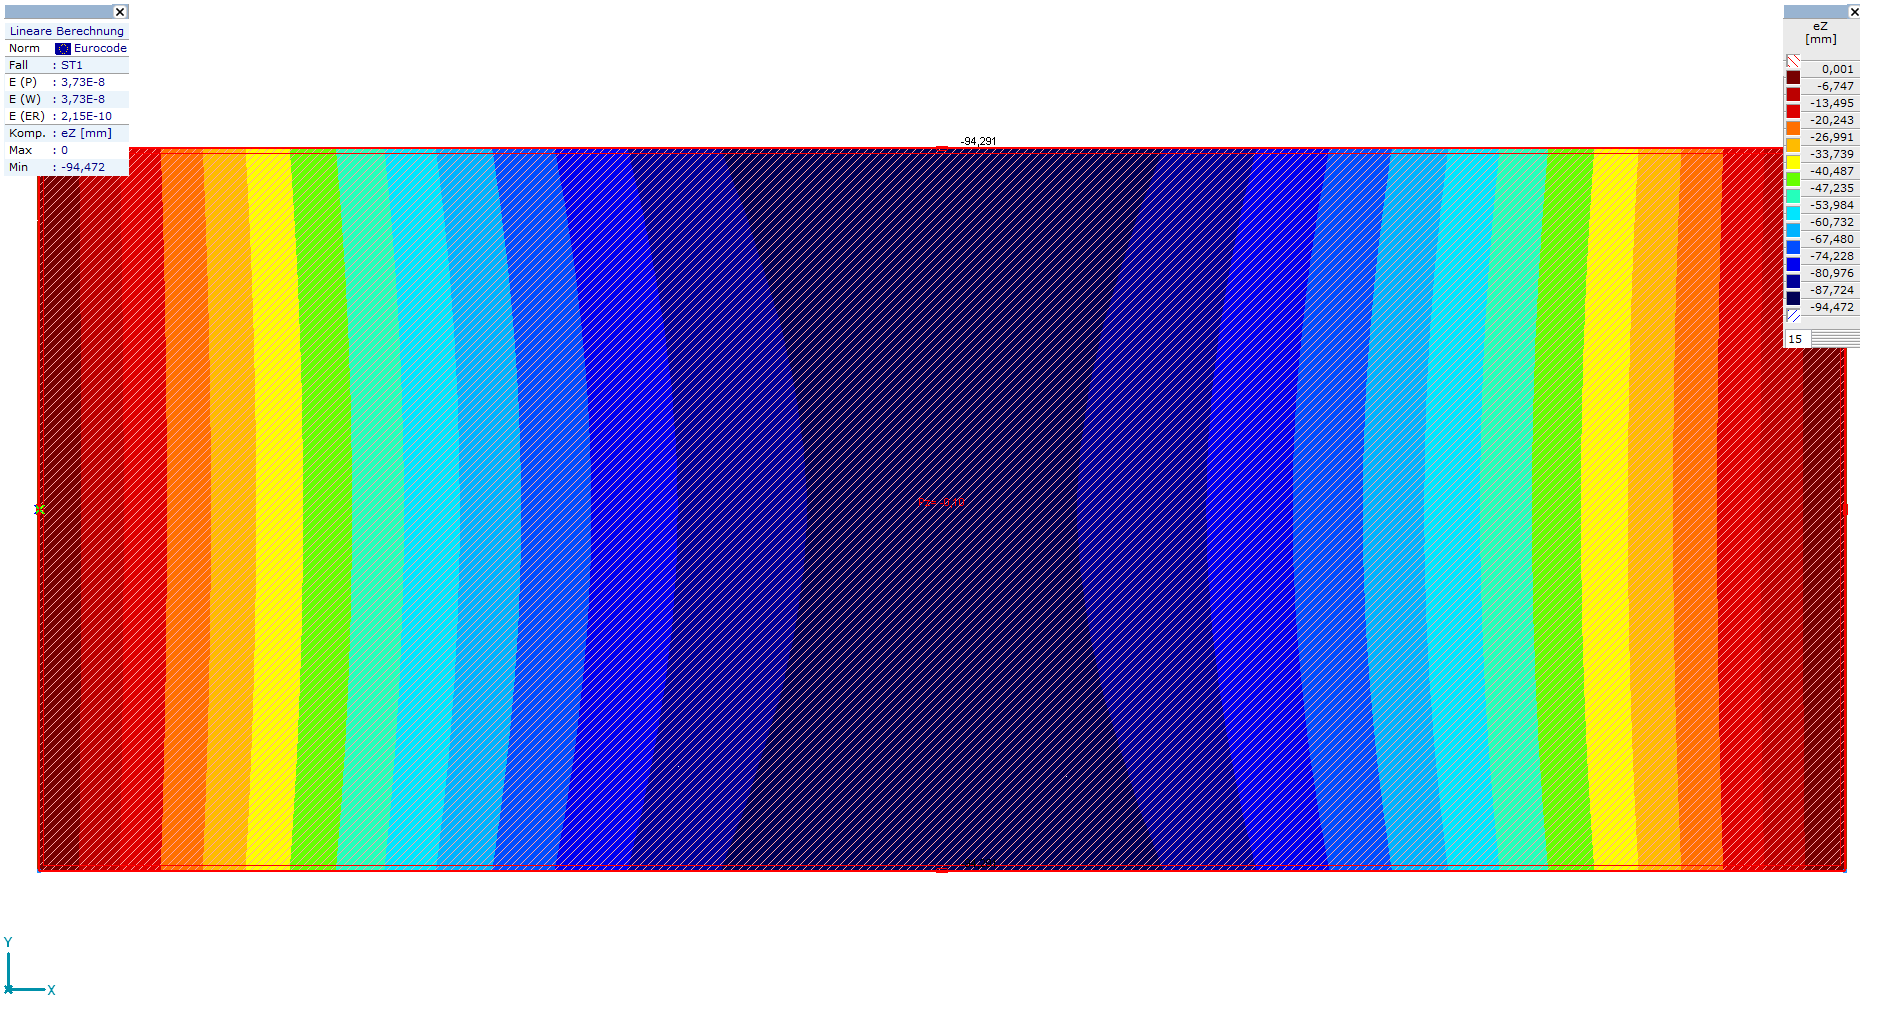

In [12]:
# we want the domain to fill up the screen entirely
axm.View = axtlb.vTop
axm.FitInView()

# turn off the grid
GridOptions = axtlb.RGridOptions(DisplayGrid=False)
axm.Settings.SetGridOptions(GridOptions)

WriteValuesTo = axtlb.RWriteValuesTo(
    Nodes=True,
    Lines=True,
    Surfaces=False,
    MinMaxOnly=True
)

BasicDispParams = axtlb.RBasicDisplayParameters_V153(
    ResultComponent=axtlb.rc_d_eZ,
    Scale=1.0,
    DisplayMode=axtlb.dmIsosurfaces2D,
    DisplayShape=axtlb.dsUndeformed,
    WriteValuesTo=WriteValuesTo
)

ExtDispParams = axtlb.RExtendedDisplayParameters_V153(
    BasicDispParams=BasicDispParams,
    DisplayAnalysisType=axtlb.datLinear,
    ResultType=axtlb.rtLoadCase
)
axm.Windows.SetStaticDisplayParameters_V153(1, ExtDispParams, 1, [])

axm.Windows.ReDraw()
imgpath = wdir + 'ss_beam_P_ez.bmp'
axm.Windows[1].SaveWindowToBitmap(axtlb.wcmColour, imgpath)
axvm.BringToFront()
axm.Windows[1].screenshot()

In [13]:
axm.Lines[1]

IAxisVMLine,Information
Length,4.000e-01
Volume,0.000e+00
Weight,0.000e+00


In [14]:
axm.Domains[1]

IAxisVMDomain,Information
Name,1
Index,1
UID,1
N Surfaces,590
Area,4.000e+01
Volume,8.000e-01
Weight,6.280e+03


In [15]:
axm.Domains

IAxisVMDomains

In [16]:
import matplotlib.pyplot as plt

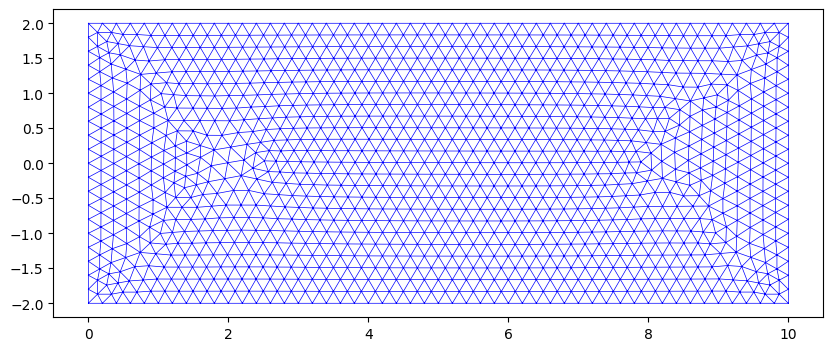

In [17]:
fig, ax = plt.subplots(figsize=(20, 4))
axm.Domains[1].plot(fig=fig, ax=ax)

COMError: (-2147023170, 'Der Remoteprozeduraufruf ist fehlgeschlagen.', (None, None, None, 0, None))

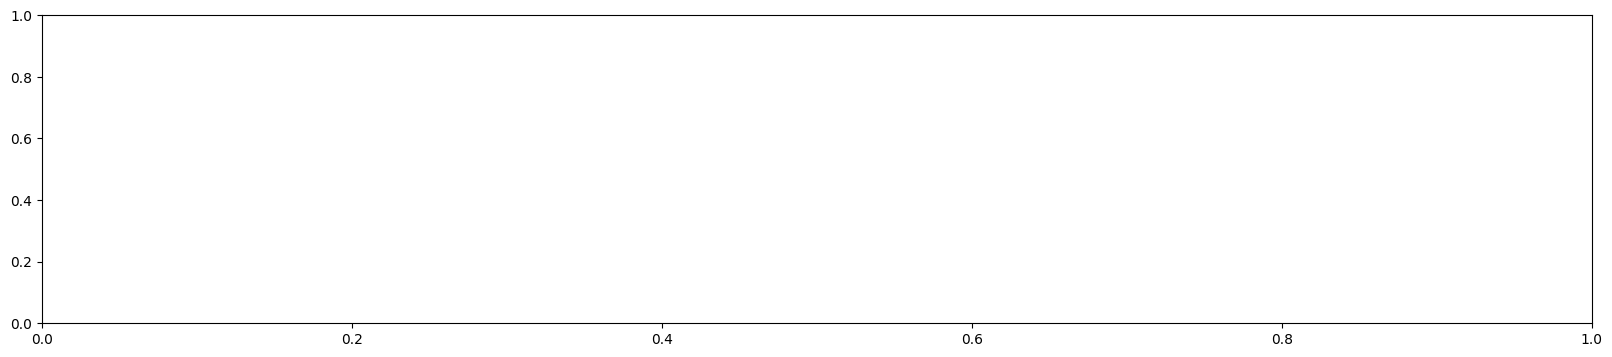

In [18]:
fig, ax = plt.subplots(figsize=(20, 4))

mpl_kw = dict(nlevels=15, cmap='rainbow', axis='on', offset=0., cbpad=0.5,
              cbsize=0.3, cbpos='right', fig=fig, ax=ax)

axm.Domains[1].plot_dof_solution(component='uz', mpl_kw=mpl_kw, case=1)

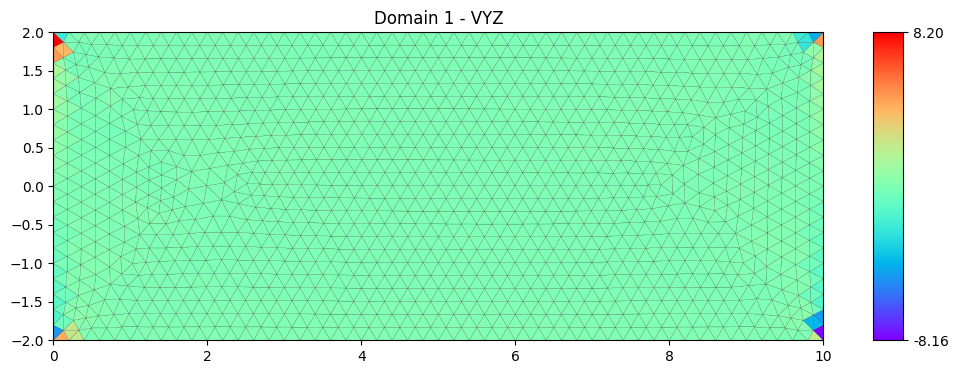

In [ ]:

fig, ax = plt.subplots(figsize=(20, 4))
mpl_kw = dict(nlevels=15, cmap='rainbow', axis='on', offset=0., cbpad=0.5,
              cbsize=0.3, cbpos='right', fig=fig, ax=ax)
axm.Domains[1].plot_forces(component='vyz', mpl_kw=mpl_kw, case=1)

In [ ]:

fig, ax = plt.subplots(figsize=(20, 4))
mpl_kw = dict(nlevels=15, cmap='rainbow', axis='on', offset=0., cbpad=0.5,
              cbsize=0.3, cbpos='right', fig=fig, ax=ax)
axm.Domains[1].plot(component='vyz', mpl_kw=mpl_kw, case=1)